Stitching imagen 2 de 3...
Stitching imagen 3 de 3...


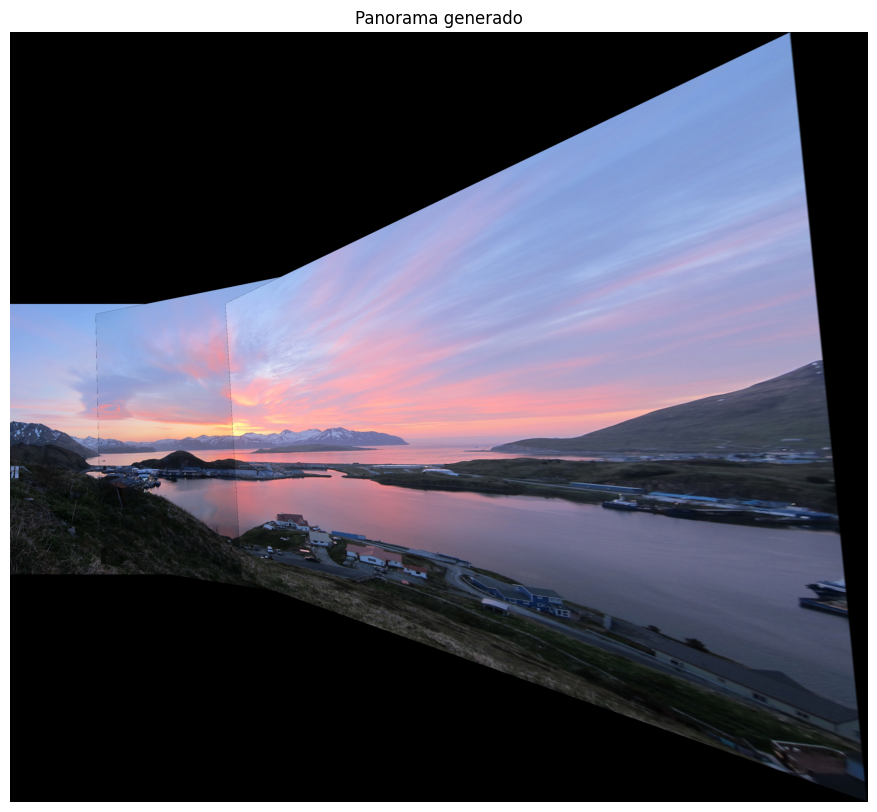

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

def stitch_pair(img1, img2):
    sift = cv2.SIFT_create()

    gray1 = cv2.cvtColor(img1, cv2.COLOR_RGB2GRAY)
    gray2 = cv2.cvtColor(img2, cv2.COLOR_RGB2GRAY)

    kp1, desc1 = sift.detectAndCompute(gray1, None)
    kp2, desc2 = sift.detectAndCompute(gray2, None)

    matcher = cv2.BFMatcher()
    matches = matcher.knnMatch(desc2, desc1, k=2)

    good = []
    for m, n in matches:
        if m.distance < 0.75 * n.distance:
            good.append(m)

    if len(good) < 4:
        print("No hay suficientes matches")
        return img1

    pts1 = np.float32([kp1[m.trainIdx].pt for m in good])
    pts2 = np.float32([kp2[m.queryIdx].pt for m in good])

    H, _ = cv2.findHomography(pts2, pts1, cv2.RANSAC)
    H = np.array(H, dtype=np.float32)


    height1, width1 = img1.shape[:2]
    height2, width2 = img2.shape[:2]

    corners_img2 = np.float32([[0,0],[0,height2],[width2,height2],[width2,0]]).reshape(-1,1,2)
    warped_corners = cv2.perspectiveTransform(corners_img2, H)

    all_corners = np.concatenate((np.float32([[0,0],[0,height1],[width1,height1],[width1,0]]).reshape(-1,1,2), warped_corners), axis=0)

    [xmin, ymin] = np.int32(np.min(all_corners, axis=0).ravel() - 0.5)
    [xmax, ymax] = np.int32(np.max(all_corners, axis=0).ravel() + 0.5)

    translation = [-xmin, -ymin]
    H_translation = np.array([[1, 0, translation[0]],
                          [0, 1, translation[1]],
                          [0, 0, 1]], dtype=np.float32)


    size = (xmax - xmin, ymax - ymin)

    # Warp ambas imágenes al mismo canvas
    warped_img1 = cv2.warpPerspective(img1, H_translation, size)
    warped_img2 = cv2.warpPerspective(img2, H_translation @ H, size)

    # Blending simple
    mask1 = np.any(warped_img1 > 0, axis=2)
    mask2 = np.any(warped_img2 > 0, axis=2)

    panorama = warped_img1.copy()
    panorama[mask2] = warped_img2[mask2]

    return panorama

# Cargar imágenes en orden (usa tus propias rutas aquí)
folder = "images/"
image_files = sorted([f for f in os.listdir(folder) if f.endswith((".jpg", ".png"))])
images = [cv2.cvtColor(cv2.imread(os.path.join(folder, f)), cv2.COLOR_BGR2RGB) for f in image_files]

# Crear panorama recursivo de izquierda a derecha
panorama = images[0]
for i in range(1, len(images)):
    print(f"Stitching imagen {i+1} de {len(images)}...")
    panorama = stitch_pair(panorama, images[i])

# Mostrar resultado
plt.figure(figsize=(20,10))
plt.imshow(panorama)
plt.axis("off")
plt.title("Panorama generado")
plt.show()